# Deep Vision Projekt - Paper Group Normalization (Marco Deuscher)

In [13]:
LOCAL = True

In [12]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
import time, datetime, os

from tqdm import tqdm

model_root_dir = ""
if not LOCAL:
    model_root_dir = "/content/gdrive/MyDrive/DVExam/"
    from google.colab import drive
    drive.mount("/content/gdrive")


print("GPU available:", torch.cuda.is_available())
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Device used:", device)

%load_ext tensorboard

GPU available: True
Device used: cuda:0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Implementation

### Group Normalization

In [14]:
class GroupNorm(nn.Module):
  """
  Implementation of the GroupNorm layer - using the implementation provided in the original paper
  """
  def __init__(self, channels, groups=16, eps=1e-5, last_residual=False):
    super(GroupNorm, self).__init__()
    
    self.gamma = nn.Parameter(torch.zeros([1, channels, 1, 1])) if last_residual else nn.Parameter(torch.ones([1, channels, 1, 1]))
    self.beta = nn.Parameter(torch.zeros([1, channels, 1, 1]))
    self.num_groups = groups
    self.eps = eps

  def forward(self, t: torch.Tensor):
    bs, C, H, W = t.shape
    t = t.view(bs * self.num_groups, -1)

    mean = t.mean(dim=1, keepdim=True)
    var = t.var(dim=1, keepdim=True)
    t = (t - mean) / torch.sqrt(var + self.eps)

    t = t.view([bs, C, H, W])

    return self.gamma * t + self.beta

### ResNet-34

In [15]:
class BasicResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, projection_shortcut=False, group_norm=False):
    super(BasicResidualBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=(2 if projection_shortcut else 1), padding=1)
    self.norm1 = GroupNorm(out_channels) if group_norm else nn.BatchNorm2d(out_channels)
    
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
    self.norm2 = GroupNorm(out_channels, last_residual=True) if group_norm else nn.BatchNorm2d(out_channels)

    self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding=0) if projection_shortcut else nn.Identity()

  def forward(self, t: torch.Tensor):
    residual_skip = t

    t = F.relu(self.norm1(self.conv1(t)))
    t = self.norm2(self.conv2(t))

    residual_skip = self.skip_conv(residual_skip)

    return F.relu(t + residual_skip)

class ResNet34(nn.Module):
  def __init__(self, input_size=(32, 32), num_classes=10, group_norm=False, input_channels=3):
    super(ResNet34, self).__init__()

    self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
    self.norm1 = GroupNorm(64) if group_norm else nn.BatchNorm2d(64)

    # Stacking BasicResidualBlocks
    self.layer01 = nn.Sequential(
          BasicResidualBlock(64, 64, group_norm=group_norm),    
          BasicResidualBlock(64, 64, group_norm=group_norm),
          BasicResidualBlock(64, 64, group_norm=group_norm)            
    )

    self.layer02 = nn.Sequential(
          BasicResidualBlock(64, 128, group_norm=group_norm, projection_shortcut=True),
          BasicResidualBlock(128, 128, group_norm=group_norm),
          BasicResidualBlock(128, 128, group_norm=group_norm),
          BasicResidualBlock(128, 128, group_norm=group_norm)                
    )

    self.layer03 = nn.Sequential(
          BasicResidualBlock(128, 256, group_norm=group_norm, projection_shortcut=True),
          BasicResidualBlock(256, 256, group_norm=group_norm),
          BasicResidualBlock(256, 256, group_norm=group_norm),
          BasicResidualBlock(256, 256, group_norm=group_norm),
          BasicResidualBlock(256, 256, group_norm=group_norm),
          BasicResidualBlock(256, 256, group_norm=group_norm)                 
    )

    self.layer04 = nn.Sequential(
          BasicResidualBlock(256, 512, group_norm=group_norm, projection_shortcut=True),
          BasicResidualBlock(512, 512, group_norm=group_norm),
          BasicResidualBlock(512, 512, group_norm=group_norm)                
    )

    self.pool2 = nn.AvgPool2d(kernel_size=4)
    self.fc = nn.Linear(512, num_classes)


  def forward(self, t: torch.Tensor):
    t = F.relu(self.norm1(self.conv1(t)))

    t = self.layer01(t)
    t = self.layer02(t)
    t = self.layer03(t)
    t = self.layer04(t)

    t = self.pool2(t)
    t = t.reshape([t.shape[0], t.shape[1]])
    t = self.fc(t)

    return t

### Dataset

In [16]:

CLASSES_CIFAR10 = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

def getCIFARLoader(train, batch_size):
  augmentations = None
  if train:
    augmentations = transforms.Compose([
          #transforms.RandomCrop(32, padding=4),
          #transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
  else:
    augmentations = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])


  dataset = torchvision.datasets.CIFAR10(root="./data", train=train, download=True, transform=augmentations)

  return torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, num_workers=2)


CLASSES_FASHIONMNIST = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

def getFashionMNISTLoader(train, batch_size):
  augmentations = None
  if train:
    augmentations = transforms.Compose([
          transforms.RandomCrop(28, padding=4),                             
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
      ])
  else:
    augmentations = transforms.Compose([
          transforms.ToTensor(),
      ])
  
  dataset = torchvision.datasets.FashionMNIST(root="./data", train=train, download=True, transform=augmentations)

  return torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Data-shape: torch.Size([10, 3, 32, 32]) - Label-shape: torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

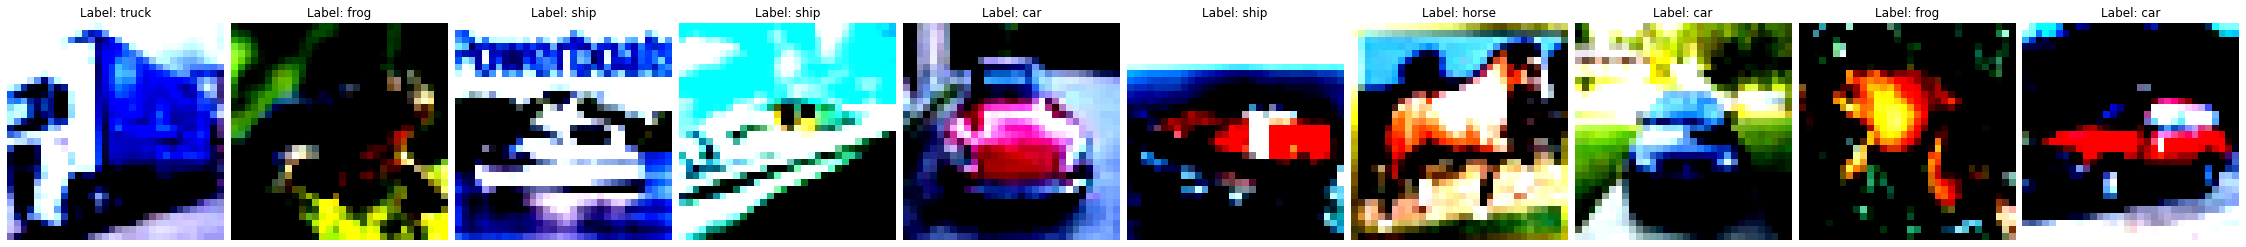

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

loader = getCIFARLoader(train=True, batch_size=10)
data, label = next(iter(loader))
print(f"Data-shape: {data.shape} - Label-shape: {label.shape}")

fig = plt.figure(figsize=(40., 40.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1, 10),  
                 axes_pad=0.1)


for idx, ax in enumerate(grid):
  ax.imshow(data[idx].permute([1, 2, 0]))
  ax.axis("off")
  ax.set_title(f"Label: {CLASSES_CIFAR10[label[idx]]}")


Data-shape: torch.Size([10, 1, 28, 28]) - Label-shape: torch.Size([10])


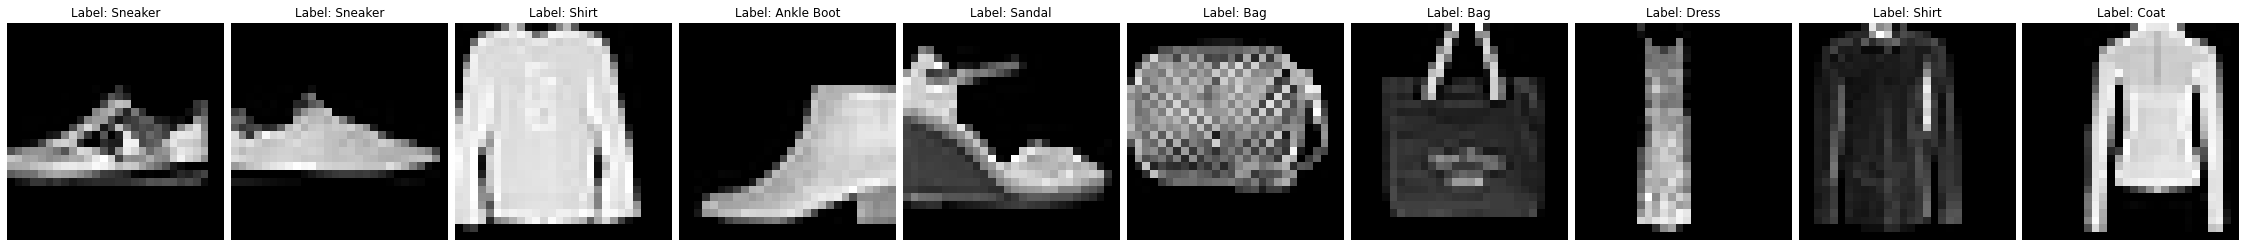

In [18]:
loader = getFashionMNISTLoader(train=True, batch_size=10)
data, label = next(iter(loader))
print(f"Data-shape: {data.shape} - Label-shape: {label.shape}")


fig = plt.figure(figsize=(40., 40.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1, 10),  
                 axes_pad=0.1)

for idx, ax in enumerate(grid):
  ax.imshow(data[idx].squeeze(0), cmap="gray")
  ax.axis("off")
  ax.set_title(f"Label: {CLASSES_FASHIONMNIST[label[idx]]}")

## Training

In [19]:
%tensorboard --logdir runs

Launching TensorBoard...

In [ ]:
def train_network(epochs=50, batch_size=128, group_norm=False, dataset="CIFAR10"):
  assert dataset in ["CIFAR10", "FashionMNIST"], "Other datasets are not implemented"
  os.makedirs("model", exist_ok=True)

  model = ResNet34(num_classes=10, group_norm=group_norm)
  model.to(device)

  loss = nn.CrossEntropyLoss()

  #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
  
  #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
  #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs//3, 2*epochs//3], gamma=0.5)

  train_loader = None
  test_loader = None
  if dataset == "CIFAR10":
    train_loader = getCIFARLoader(train=True, batch_size=batch_size)
    test_loader = getCIFARLoader(train=False, batch_size=batch_size)
  else:
    train_loader = getFashionMNISTLoader(train=True, batch_size=batch_size)
    test_loader = getFashionMNISTLoader(train=False, batch_size=batch_size)
  

  time_now = datetime.datetime.now()
  dt_string = time_now.strftime("%d-%m-%Y-%H-%M")
  modelid_str = f"model_{dt_string}_{batch_size}"
  writer = SummaryWriter(log_dir=f"runs/{modelid_str}",
                           comment=modelid_str,
                           flush_secs=30)

  best_acc = 0
  print("~~~Starting training loop~~~")

  for epoch in range(epochs):
    running_loss = 0
    correct = 0
    for idx, (data, label) in enumerate(train_loader):
      data, label = data.to(device), label.to(device)

      pred = model(data)

      loss_val = loss(pred, label)
      optimizer.zero_grad()
      loss_val.backward()
      optimizer.step()

      running_loss += loss_val.item()
      class_pred = torch.argmax(pred, dim=1)
      correct += (class_pred == label).float().sum()

      if idx%100 == 99:
        print(f"Epoch ({epoch}) - Idx ({idx}) - Current Loss - ({running_loss / idx})")

    
    print(f"Average-Loss of epoch: {running_loss / len(train_loader)} - Acc. on Train {100 * correct / (batch_size * len(train_loader))}")
    for name, param in model.named_parameters():
        writer.add_histogram(name, param, epoch)
    writer.add_scalar("Train/loss", running_loss / idx, epoch)
    writer.add_scalar("Train/acc", 100 * correct / (batch_size * len(train_loader)), epoch)

    running_loss = 0
    correct = 0
    for idx, (data, label) in enumerate(test_loader):
      data, label = data.to(device), label.to(device)
      pred = model(data)
      loss_val = loss(pred, label)

      running_loss += loss_val.item()
      class_pred = torch.argmax(pred, dim=1)
      correct += (class_pred == label).float().sum()

    curr_acc = 100 * correct / (batch_size * len(test_loader))
    writer.add_scalar("Test/loss", running_loss / idx, epoch)
    writer.add_scalar("Test/acc", curr_acc, epoch)
    print(f"Average-Loss on Test: {running_loss/idx} - Acc. on Test: {100 * correct / (batch_size * len(test_loader))}")

    if curr_acc > best_acc:
      best_acc = curr_acc
      norm_str = "GN" if group_norm else "BN"
      model_save_name = f"resnet34-epochs{epochs}-bs{batch_size}-{norm_str}.pth"
      savepath = f"{model_save_name}"
      torch.save(model.state_dict(), os.path.join(model_root_dir, "model", model_save_name))


    scheduler.step()


train_network(epochs=200, batch_size=32, group_norm=False, dataset="CIFAR10")

Epoch (0) - Idx (299) - Current Loss - (11.176393219459815)
Epoch (0) - Idx (399) - Current Loss - (8.951247972952094)
Epoch (0) - Idx (499) - Current Loss - (7.614441304025287)
Epoch (0) - Idx (599) - Current Loss - (6.722535452181987)
Epoch (0) - Idx (699) - Current Loss - (6.084105758366837)
Epoch (0) - Idx (799) - Current Loss - (5.603086450968278)
Epoch (0) - Idx (899) - Current Loss - (5.226904723747686)
Epoch (0) - Idx (999) - Current Loss - (4.922158984689264)
Epoch (0) - Idx (1099) - Current Loss - (4.670702738367068)
Epoch (0) - Idx (1199) - Current Loss - (4.472190771230168)
Epoch (0) - Idx (1299) - Current Loss - (4.303622300116442)
Epoch (0) - Idx (1399) - Current Loss - (4.156959038619232)
Epoch (0) - Idx (1499) - Current Loss - (4.027736822870113)
Average-Loss of epoch: 3.945968602226853 - Acc. on Train 14.213451385498047
Average-Loss on Test: 2.0786299036863523 - Acc. on Test: 17.701677322387695
Epoch (1) - Idx (99) - Current Loss - (2.0448199149334068)
Epoch (1) - Idx 

## Evaluation

In [ ]:
def model_eval(model_path, dataset="CIFAR10", batch_size=128, group_norm=False):
  assert dataset in ["CIFAR10", "FashionMNIST"], "Other datasets are not implemented"

  train_loader = None
  test_loader = None
  if dataset == "CIFAR10":
    test_loader = getCIFARLoader(train=False, batch_size=batch_size)
  else:
    test_loader = getFashionMNISTLoader(train=False, batch_size=batch_size)
  
  model = ResNet34(group_norm=False)
  model.load_state_dict(torch.load(model_path))

  model.eval()

  correct = 0
  for data, label in test_loader:
    data, label = data.to(device), label.to(device)
    pred = model(data)

    class_pred = torch.argmax(pred, dim=1)
    correct += (class_pred == label).float().sum()

  acc = 100 * correct / (batch_size * len(test_loader))
  return acc